In [228]:
from astropy.io import fits
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import subprocess
from sklearn.cluster import DBSCAN
from analyzeImage import analyzeImage
import keras
from keras.models import load_model
from __future__ import print_function

In [229]:
gpu_code_path = "../code/gpu/"
real_image_name = "chip_7"
real_image_path = gpu_code_path+"images/"+real_image_name
psi_image_path = gpu_code_path+"output-images/psi"
phi_image_path = gpu_code_path+"output-images/phi"

In [230]:
def execute(cmd):
    popen = subprocess.Popen(cmd, stdout=subprocess.PIPE, universal_newlines=True)
    for stdout_line in iter(popen.stdout.readline, ""):
        yield stdout_line 
    popen.stdout.close()
    return_code = popen.wait()
    if return_code:
        raise subprocess.CalledProcessError(return_code, cmd)

In [231]:
paramsFile = open('../code/gpu/debug/parameters.config', 'w')
paramsFile.write(
"""Debug ................ : 1
Image Count .......... : 5
Generate Images ...... : 0
Image Width .......... : 500
Image Height ......... : 500
PSF Sigma ............ : 1.0
Object Brightness .... : 360.0
Object Initial x ..... : 320.0
Object Initial y ..... : 180.0
Velocity x ........... : -1.3
Velocity y ........... : -0.2
Background Level ..... : 1024.0
Background Sigma ..... : 32.0
Mask Threshold ....... : 40.0
Mask Penalty ......... : -0.035
Angles to Search ..... : 30
Minimum Angle ........ : 0.0
Maximum Angle ........ : 0.8
Velocities to Search . : 20
Minimum Velocity ..... : 300
Maximum Velocity ..... : 500
Write to file ........ : 1
Source Images Path ... : ../../{source}/
Psi Images Path ...... : ../../{psi}/
Phi Images Path....... : ../../{phi}/
""".format( source=real_image_path, psi=psi_image_path, phi=phi_image_path ))
paramsFile.close()

In [232]:
popen = subprocess.Popen( "./clearImages.sh", stdout=subprocess.PIPE, 
                         stderr=subprocess.PIPE)
popen.wait()
output = popen.stderr.read()
output += popen.stdout.read()
print( output)

In [233]:
for path in execute("./search.sh"):
    print(path, end="")

Image Count ..........  : 5
Generate Images ......  : 0
Image Width ..........  : 500
Image Height .........  : 500
PSF Sigma ............  : 1.0
Object Brightness ....  : 360.0
Object Initial x .....  : 320.0
Object Initial y .....  : 180.0
Velocity x ...........  : -1.3
Velocity y ...........  : -0.2
Background Level .....  : 1024.0
Background Sigma .....  : 32.0
Mask Threshold .......  : 40.0
Mask Penalty .........  : -0.035
Angles to Search .....  : 30
Minimum Angle ........  : 0.0
Maximum Angle ........  : 0.8
Velocities to Search .  : 20
Minimum Velocity .....  : 300
Maximum Velocity .....  : 500
Write to file ........  : 1
Source Images Path ...  : ../../../code/gpu/images/chip_7/
Psi Images Path ......  : ../../../code/gpu/output-images/psi/
Phi Images Path.......  : ../../../code/gpu/output-images/phi/
Using Kernel Size 5X5
| 0.004 | 0.015 | 0.023 | 0.015 | 0.004 | 
 ---------------------------------------
| 0.015 | 0.058 | 0.093 | 0.058 | 0.015 | 
 ---------------------------

In [234]:
raw_results = np.genfromtxt('../code/gpu/debug/results/results.txt', names=True)

In [235]:
image_mjd = []

for filename in sorted(os.listdir(real_image_path)):
    hdulist = fits.open(os.path.join(real_image_path, filename))
    image_mjd.append(hdulist[0].header['MJD'])

image_mjd = np.array(image_mjd)
image_times = image_mjd - image_mjd[0]
#image_times*=24.

Load Psi Images

In [236]:
hdulist = fits.open(os.path.join(psi_image_path, os.listdir(psi_image_path)[0]))
num_images = len(os.listdir(psi_image_path))
image_shape = np.shape(hdulist[0].data)
im_psi_array = np.zeros((num_images, image_shape[0], image_shape[1]))

for idx, filename in list(enumerate(sorted(os.listdir(psi_image_path)))):

    #print (str('Loaded ' + filename))

    image_file = os.path.join(psi_image_path, filename)
    hdulist = fits.open(image_file)
    im_psi_array[idx] = hdulist[0].data#*mask


Load Phi Images (for potentially making psi/phi stamps)

In [237]:
hdulist = fits.open(os.path.join(phi_image_path, os.listdir(phi_image_path)[0]))
num_images = len(os.listdir(phi_image_path))
image_shape = np.shape(hdulist[0].data)
im_phi_array = np.zeros((num_images, image_shape[0], image_shape[1]))

for idx, filename in list(enumerate(sorted(os.listdir(phi_image_path)))):

   # print (str('Loaded ' + filename))

    image_file = os.path.join(phi_image_path, filename)
    hdulist = fits.open(image_file)
    im_phi_array[idx] = hdulist[0].data#*mask


In [238]:
hdulist = fits.open(os.path.join(real_image_path, os.listdir(real_image_path)[0]))
num_images = len(os.listdir(real_image_path))
image_shape = np.shape(hdulist[1].data)
im_array = np.zeros((num_images, image_shape[0], image_shape[1]))


for idx, filename in list(enumerate(sorted(os.listdir(real_image_path)))):

   # print( str('Loaded ' + filename))

    image_file = os.path.join(real_image_path, filename)
    hdulist = fits.open(image_file)
    im_array[idx] = hdulist[1].data#*mask


In [239]:
ai = analyzeImage()

In [240]:
model = load_model('../data/kbmod_model.h5')

In [241]:
results = raw_results[0:200000]
results

array([(1571.0, 599.0, 0.0, 0.0, 363.136, 142.241, 6.109, 517.61),
       (1571.0, 600.0, 0.0, 0.0, 366.799, 132.508, 6.034, 511.243),
       (1570.0, 600.0, 0.0, 0.0, 376.204, 135.906, 5.707, 483.791), ...,
       (1655.0, 2157.0, 0.0, 0.0, 465.125, 154.138, 1.544, 125.653),
       (1861.0, 2159.0, 0.0, 0.0, 455.917, 61.152, 1.544, 127.06),
       (1717.0, 2160.0, 0.0, 0.0, 264.692, 197.074, 1.543, 125.734)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8'), ('theta_par', '<f8'), ('theta_perp', '<f8'), ('v_x', '<f8'), ('v_y', '<f8'), ('likelihood', '<f8'), ('est_flux', '<f8')])

In [247]:
results_to_cluster = results#filtered_results
arg = dict(eps=0.055, min_samples=1, n_jobs=-1)
clustered_results = ai.clusterResults(results_to_cluster, dbscan_args=arg)#, im_array, image_times)
clustered_results =  results_to_cluster[np.array(clustered_results[1], dtype=np.int)]
#best_targets = range(stamp_count)
#best_targets

In [248]:
print( len(clustered_results) )
clustered_results

995


array([(1571.0, 599.0, 0.0, 0.0, 363.136, 142.241, 6.109, 517.61),
       (339.0, 2941.0, 0.0, 0.0, 405.155, 110.677, 2.36, 198.131),
       (212.0, 1004.0, 0.0, 0.0, 363.136, 142.241, 2.149, 181.282),
       (1396.0, 1426.0, 0.0, 0.0, 485.651, 65.14, 2.116, 173.885),
       (1246.0, 710.0, 0.0, 0.0, 350.637, 342.277, 2.086, 172.371),
       (211.0, 1003.0, 0.0, 0.0, 428.314, 167.772, 2.073, 172.995),
       (1496.0, 1963.0, 0.0, 0.0, 434.38, 70.1, 2.022, 166.585),
       (1789.0, 3185.0, 0.0, 0.0, 428.44, 237.78, 2.016, 163.699),
       (1113.0, 116.0, 0.0, 0.0, 437.625, 171.419, 1.986, 166.297),
       (132.0, 2319.0, 0.0, 0.0, 341.444, 226.971, 1.941, 160.688),
       (1214.0, 3965.0, 0.0, 0.0, 300.0, 0.0, 1.932, 157.153),
       (1017.0, 190.0, 0.0, 0.0, 315.913, 50.982, 1.926, 161.561),
       (1115.0, 3372.0, 0.0, 0.0, 487.215, 52.168, 1.914, 155.954),
       (1532.0, 3500.0, 0.0, 0.0, 381.758, 149.536, 1.914, 158.145),
       (1888.0, 3210.0, 0.0, 0.0, 453.388, 123.853, 1.911, 1

In [244]:
filtered_results = ai.filter_results(im_array, clustered_results, image_times, model, chunk_size=1)

Finished chunk 1 of 2861
Finished chunk 2 of 2861
Finished chunk 3 of 2861
Finished chunk 4 of 2861
Finished chunk 5 of 2861
Finished chunk 6 of 2861
Finished chunk 7 of 2861
Finished chunk 8 of 2861
Finished chunk 9 of 2861
Finished chunk 10 of 2861
Finished chunk 11 of 2861
Finished chunk 12 of 2861
Finished chunk 13 of 2861
Finished chunk 14 of 2861
Finished chunk 15 of 2861
Finished chunk 16 of 2861
Finished chunk 17 of 2861
Finished chunk 18 of 2861
Finished chunk 19 of 2861
Finished chunk 20 of 2861
Finished chunk 21 of 2861
Finished chunk 22 of 2861
Finished chunk 23 of 2861
Finished chunk 24 of 2861
Finished chunk 25 of 2861
Finished chunk 26 of 2861
Finished chunk 27 of 2861
Finished chunk 28 of 2861
Finished chunk 29 of 2861
Finished chunk 30 of 2861
Finished chunk 31 of 2861
Finished chunk 32 of 2861
Finished chunk 33 of 2861
Finished chunk 34 of 2861
Finished chunk 35 of 2861
Finished chunk 36 of 2861
Finished chunk 37 of 2861
Finished chunk 38 of 2861
Finished chunk 39 of 

In [245]:
print( len(filtered_results) )
filtered_results

7


array([(1571.0, 599.0, 0.0, 0.0, 363.136, 142.241, 6.109, 517.61),
       (1325.0, 1270.0, 0.0, 0.0, 329.17, 321.321, 1.86, 157.859),
       (382.0, 1924.0, 0.0, 0.0, 381.758, 149.536, 1.733, 142.921),
       (539.0, 2859.0, 0.0, 0.0, 398.721, 31.966, 1.67, 137.265),
       (1615.0, 1502.0, 0.0, 0.0, 310.739, 218.727, 1.659, 136.181),
       (1615.0, 1503.0, 0.0, 0.0, 473.869, 76.473, 1.612, 132.79),
       (1616.0, 1503.0, 0.0, 0.0, 454.125, 73.286, 1.577, 129.946)], 
      dtype=[('t0_x', '<f8'), ('t0_y', '<f8'), ('theta_par', '<f8'), ('theta_perp', '<f8'), ('v_x', '<f8'), ('v_y', '<f8'), ('likelihood', '<f8'), ('est_flux', '<f8')])

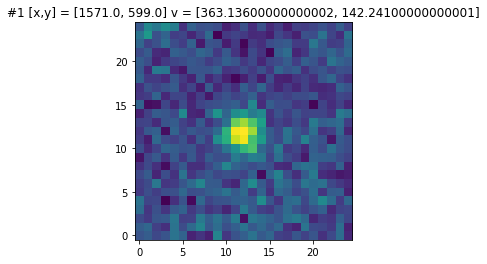

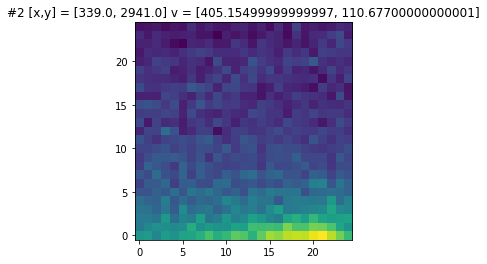

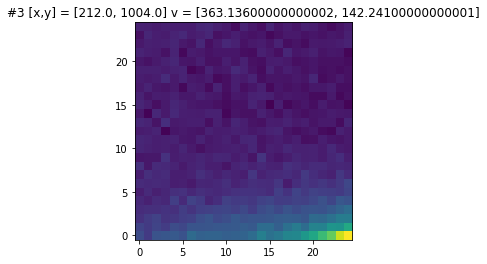

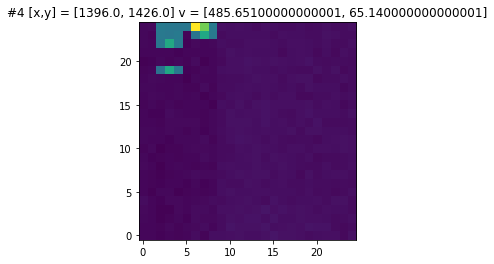

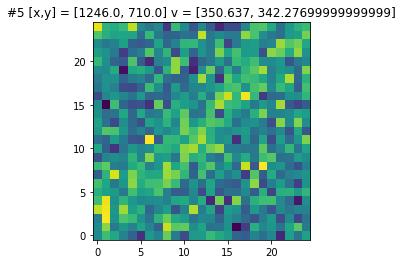

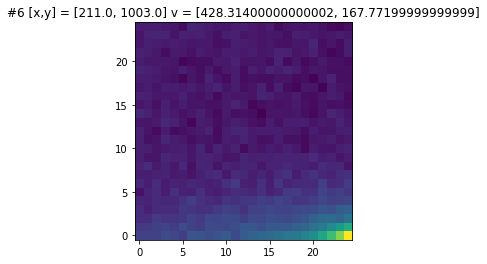

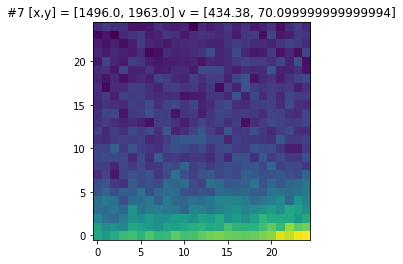

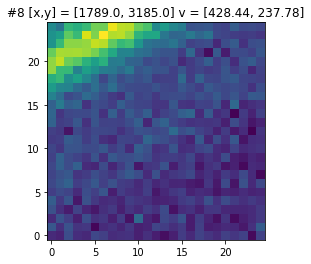

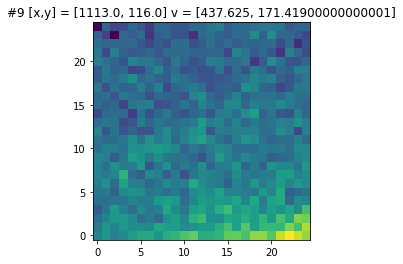

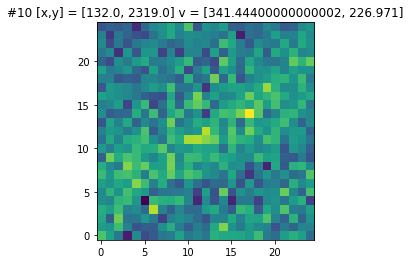

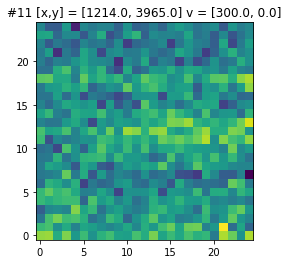

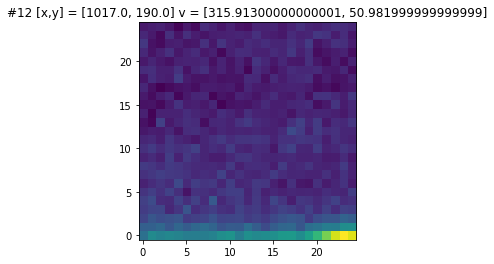

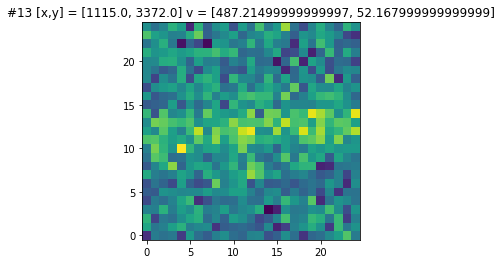

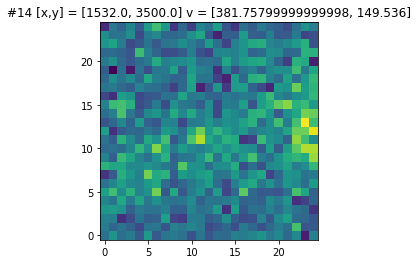

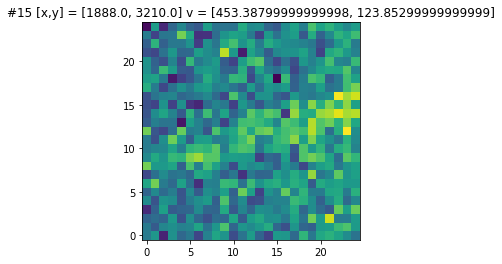

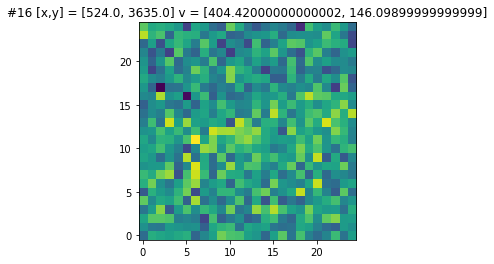

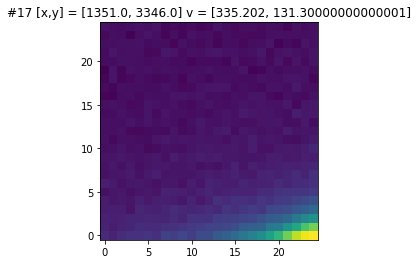

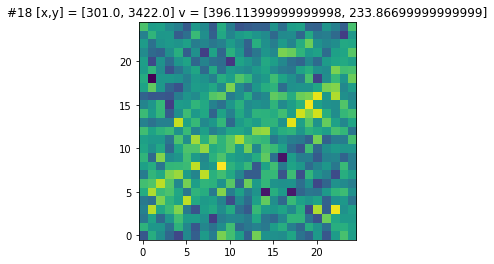

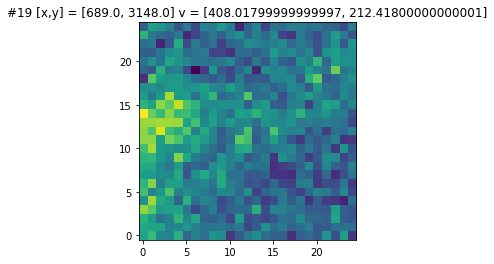

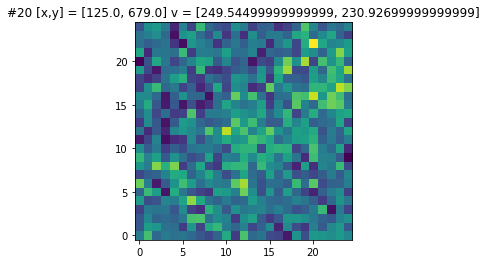

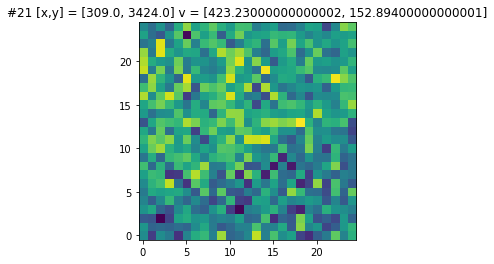

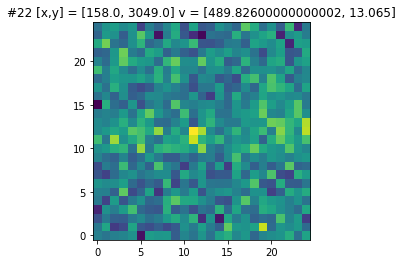

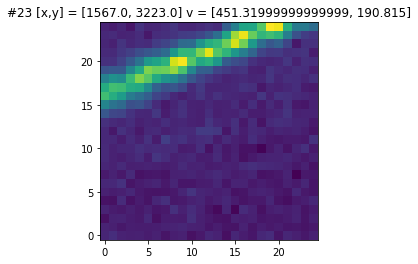

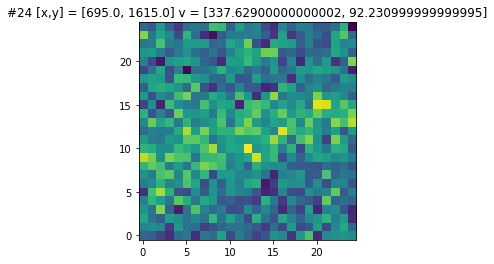

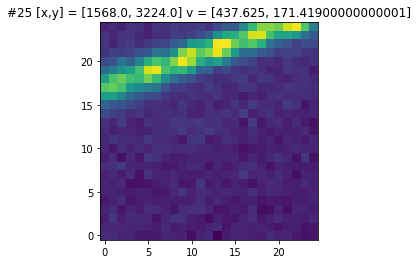

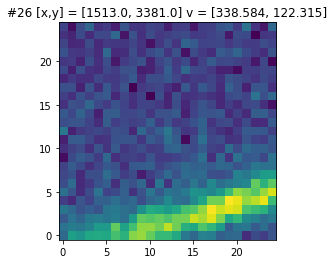

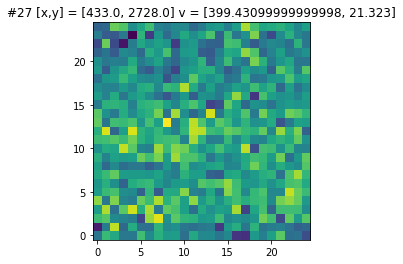

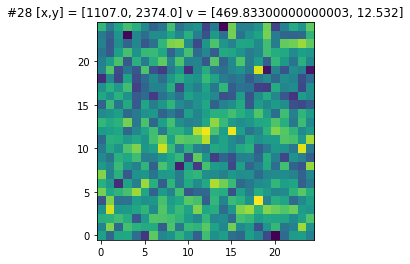

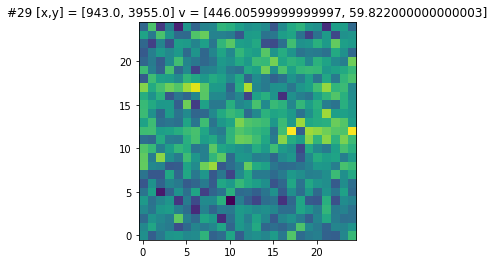

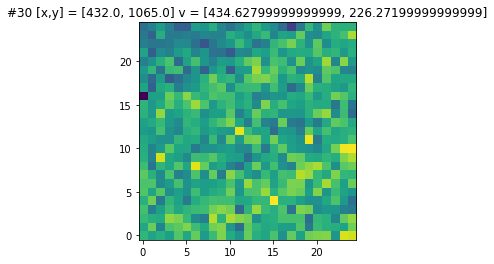

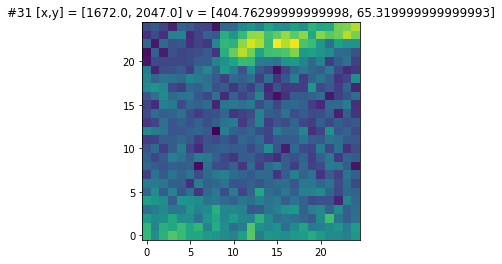

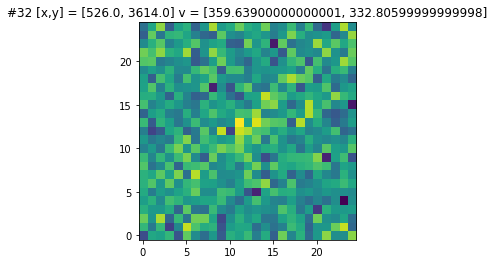

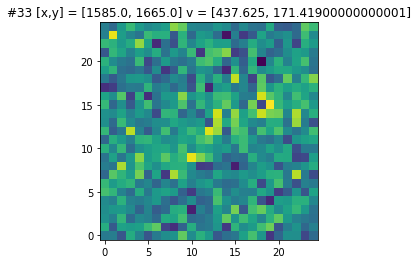

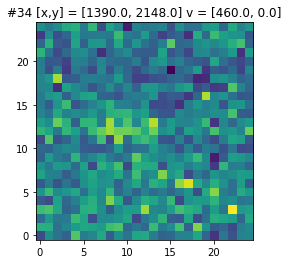

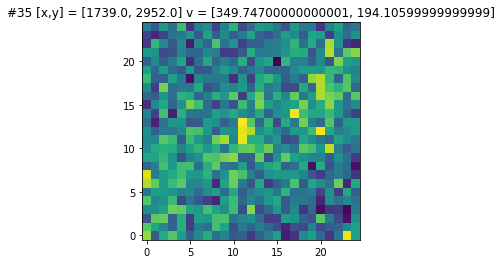

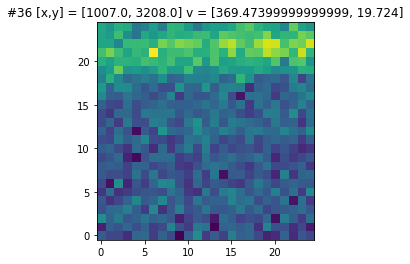

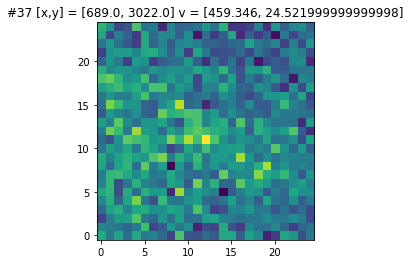

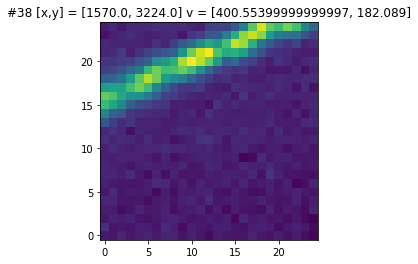

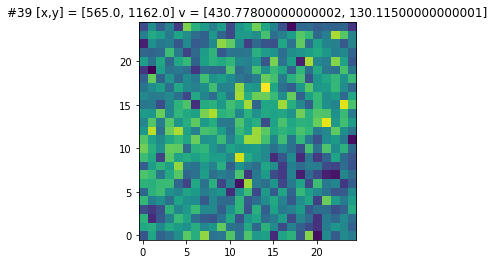

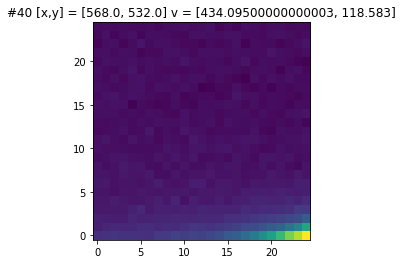

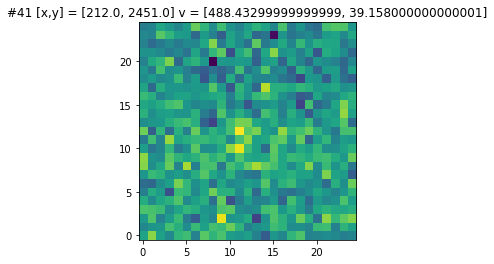

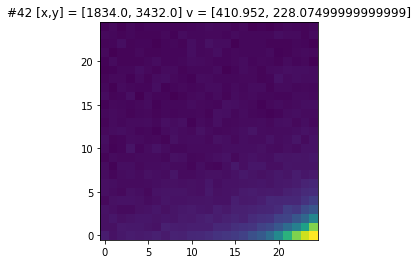

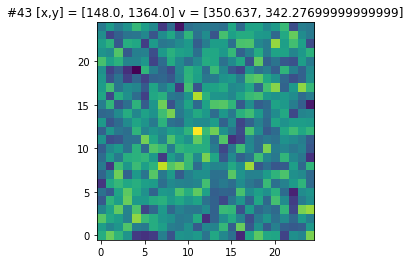

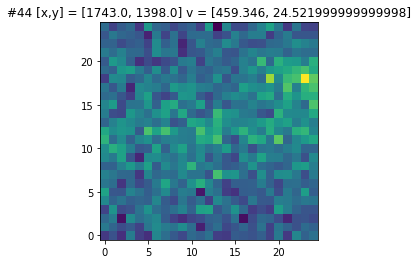

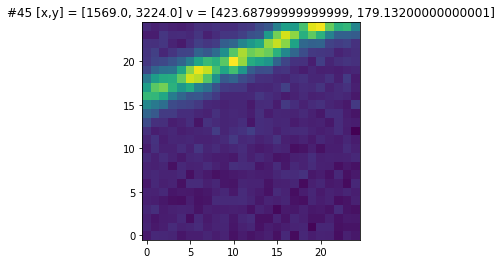

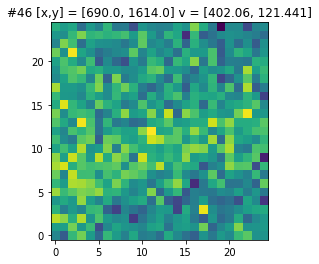

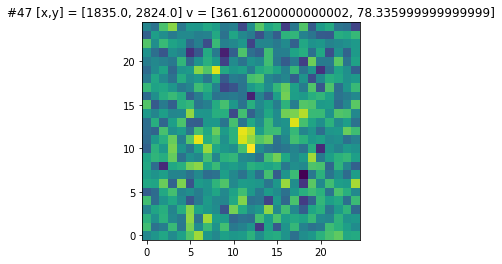

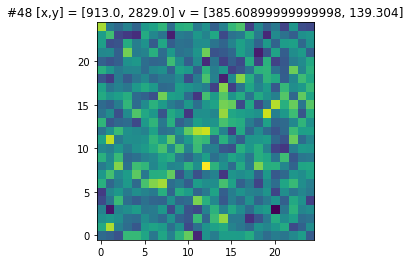

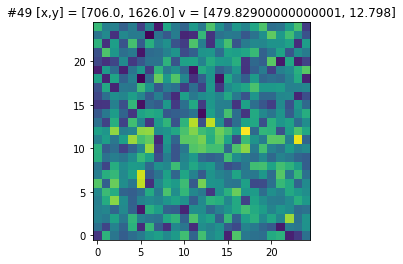

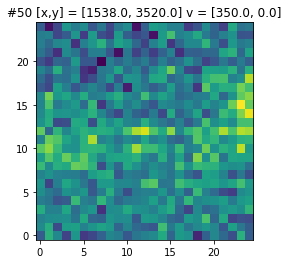

In [249]:
f_results = clustered_results#filtered_results#clustered_results
for imNum in range(min(len(f_results),50)):
    current = imNum#best_targets[imNum]
    cr = f_results[imNum]
    plt.imshow(ai.createPostageStamp(im_array,
                                         list(f_results[['t0_x', 't0_y']][current]),
                                         np.array(list(f_results[['v_x', 'v_y']][current])),
                                         image_times, [25., 25.])[0],
                    origin='lower',
               #cmap=plt.cm.Greys_r,
               interpolation='None')
    plt.title(str('#' + str(imNum+1) + ' [x,y] = ' + str(list(f_results[['t0_x', 't0_y']][current])))
                  + ' v = ' + str(list(f_results[['v_x', 'v_y']][current])))
    
    #plt.savefig("../data/stamps/c"+real_image_name[-1]+
    #             "p"+str(int(cr[0]))+"_"+str(int(cr[1]))+
    #             "v"+str(int(cr[4]))+"_"+str(int(cr[5]))+".png")
    plt.show()
